## Gsheets data loader

In [1]:
import re

def convert_google_sheet_url(url):
    # Regular expression to match and capture the necessary part of the URL
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'

    # Replace function to construct the new URL for CSV export
    # If gid is present in the URL, it includes it in the export URL, otherwise, it's omitted
    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=csv'

    # Replace using regex
    new_url = re.sub(pattern, replacement, url)

    return new_url

In [2]:
import pandas as pd

# Replace with your modified URL
url = 'https://docs.google.com/spreadsheets/d/1bwQyhW4bPA04sPy8JppZft_sM8O-j-DK06UDYR813Ik/edit?gid=0#gid=0'

new_url = convert_google_sheet_url(url)
new_url

'https://docs.google.com/spreadsheets/d/1bwQyhW4bPA04sPy8JppZft_sM8O-j-DK06UDYR813Ik/export?format=csv'

In [3]:
df = pd.read_csv(new_url)
df.head()

,Area,Data Collection Year,soil group,Land class,knit (surface),pH,SOC (%),Nitrogen N (%),Potassium K (meq/100),Phosphorus P (ug/g),Sulfur S (ug/g),Boron B (ug/g),Zinc Zn (ug/g)
0,Mithpukur,2005,belab,high ground,Clay loam,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86
1,Mithpukur,2005,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75
2,Mithpukur,2005,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95
3,Mithpukur,2005,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.0
4,Mithpukur,2005,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04


In [4]:
df = pd.read_csv(new_url)

cat_cols = ['area', 'year_data_added', 'soil_group', 'land_class', 'soil_type']

num_cols = ['pH', 'soc', 'n', 'k', 'p', 's', 'b', 'zn']

df.columns = cat_cols + num_cols
df.head()

,area,year_data_added,soil_group,land_class,soil_type,pH,soc,n,k,p,s,b,zn
0,Mithpukur,2005,belab,high ground,Clay loam,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86
1,Mithpukur,2005,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75
2,Mithpukur,2005,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95
3,Mithpukur,2005,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.0
4,Mithpukur,2005,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04


## Data Cleaning

### Numeric Features

In [5]:
# Function to identify non-numeric values
def is_numeric(x):
    try:
        pd.to_numeric(x)
        return True
    except ValueError:
        return False

# Apply the function to all elements and create a mask
non_numeric_mask = ~df[num_cols].map(is_numeric)

# Filter the DataFrame to show only rows with non-numeric values
problem_data = df[num_cols][non_numeric_mask.any(axis=1)]
problem_data.head()

,pH,soc,n,k,p,s,b,zn
67,5.50,1.69,0.10,0.10,1.8,17.5,0.`44,1.16
151,4..80,2.61,0.15,0.39,77.5,23.8,0.40,0.23
337,5.3,2.45,0.06,0.19,6.3,13..8,0.20,0.79
364,5.5,0.95,0.0032,0.51,60,17,Very Low,4
368,5.1,0.90,0.0015,0.33,80,15,Very Low,1


In [6]:
import re
import numpy as np

def clean_num_data(data):
    if pd.isna(data):
        return np.nan
    cleaned_data = re.sub(r'[^0-9.]+', '', str(data)) # remove non-numeric characters except dots
    cleaned_data = re.sub(r'\.{2,}', '.', cleaned_data) # fix series of dots (Ex. 0..01)
    cleaned_data = re.sub(r'^\.', '', cleaned_data) # remove dot at the beginning (Ex. .0.01)
    cleaned_data = re.sub(r'(\d*\.\d*)\.', r'\1', cleaned_data) # keep first dot remove the others (0.0.1)

    if not cleaned_data:
        return np.nan
    else:
        return float(cleaned_data)

cleaned_nums = df[num_cols].map(lambda x: clean_num_data(x))

View Before and After Cleaning

In [7]:
new_order = [col for pair in zip(df[num_cols].columns, cleaned_nums.add_prefix('after_').columns) for col in pair]

pd.concat([df[num_cols], cleaned_nums.add_prefix('after_')], axis=1)[new_order][non_numeric_mask.any(axis=1)]

,pH,after_pH,soc,after_soc,n,after_n,k,after_k,p,after_p,s,after_s,b,after_b,zn,after_zn
67,5.50,5.5,1.69,1.69,0.10,0.1000,0.10,0.10,1.8,1.8000,17.5,17.50,0.`44,0.44,1.16,1.16
151,4..80,4.8,2.61,2.61,0.15,0.1500,0.39,0.39,77.5,77.5000,23.8,23.80,0.40,0.40,0.23,0.23
337,5.3,5.3,2.45,2.45,0.06,0.0600,0.19,0.19,6.3,6.3000,13..8,13.80,0.20,0.20,0.79,0.79
364,5.5,5.5,0.95,0.95,0.0032,0.0032,0.51,0.51,60,60.0000,17,17.00,Very Low,NaN,4,4.00
368,5.1,5.1,0.90,0.90,0.0015,0.0015,0.33,0.33,80,80.0000,15,15.00,Very Low,NaN,1,1.00
369,5.0,5.0,0.57,0.57,0.0018,0.0018,0.44,0.44,26,26.0000,9,9.00,Very Low,NaN,1,1.00
370,5.8,5.8,0.80,0.80,0.0019,0.0019,0.52,0.52,170,170.0000,10,10.00,Very Low,NaN,1,1.00
372,5.2,5.2,1.30,1.30,0.0010,0.0010,0.35,0.35,185,185.0000,13,13.00,Very Low,NaN,1,1.00
374,5.5,5.5,0.90,0.90,0.0017,0.0017,0.28,0.28,10,10.0000,12,12.00,Very Low,NaN,1,1.00
376,5.6,5.6,1.50,1.50,0.0035,0.0035,0.51,0.51,60,60.0000,8,8.00,Very Low,NaN,4,4.00


In [8]:
cleaned_nums.describe()

,pH,soc,n,k,p,s,b,zn
count,618.000000,618.000000,610.000000,618.000000,617.000000,618.000000,592.000000,618.000000
mean,5.236942,1.792214,0.113299,0.459110,31.089042,15.340676,0.421182,1.039191
std,0.469949,1.034159,0.510417,3.380222,38.082877,11.062096,1.405366,0.976144
min,4.100000,0.100000,0.000200,0.000000,0.060000,0.400000,0.060000,0.080000
25%,4.900000,1.352500,0.070000,0.110000,8.780000,8.702500,0.240000,0.520000
50%,5.200000,1.700000,0.090000,0.170000,16.000000,12.600000,0.300000,0.820000
75%,5.400000,2.160000,0.110000,0.287500,37.400000,19.000000,0.410000,1.100000
max,7.800000,20.400000,12.600000,68.000000,254.700000,85.000000,34.000000,10.580000


Update df

In [9]:
df[num_cols] = cleaned_nums
df.head()

,area,year_data_added,soil_group,land_class,soil_type,pH,soc,n,k,p,s,b,zn
0,Mithpukur,2005,belab,high ground,Clay loam,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86
1,Mithpukur,2005,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75
2,Mithpukur,2005,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95
3,Mithpukur,2005,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.00
4,Mithpukur,2005,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04


## Data Analysis

In [10]:
num_col_names = {
    'pH': 'pH Levels',
    'soc': 'Soil Organic Carbon',
    'n': 'Nitrogen',
    'k': 'Potassium',
    'p': 'Phosphorus',
    's': 'Sulfur',
    'b': 'Boron',
    'zn': 'Zinc'
}

### Distribution Analysis of Features

#### Categorical Features

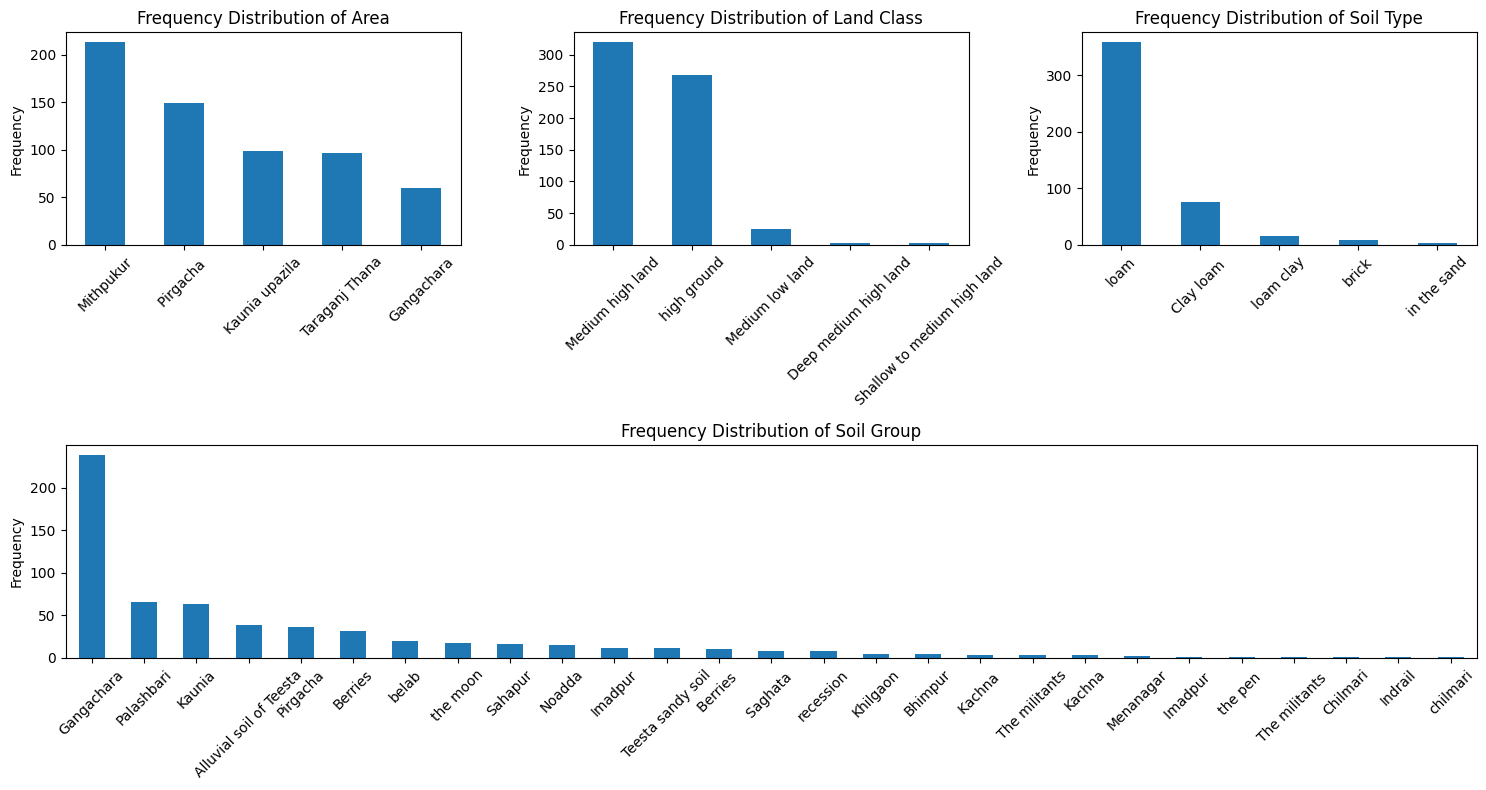

In [11]:
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure(figsize=(15, 8))

# Create gridspec layout
gs = fig.add_gridspec(2, 3)  # 2 rows, 3 columns

# Top row: 3 plots
ax1 = fig.add_subplot(gs[0, 0])  # First subplot
ax2 = fig.add_subplot(gs[0, 1])  # Second subplot
ax3 = fig.add_subplot(gs[0, 2])  # Third subplot

# Bottom row: 1 long plot spanning all columns
ax4 = fig.add_subplot(gs[1, :])  # Span all 3 columns

# fig, arr = plt.subplots(1, 4, figsize=(20, 5))
df['area'].value_counts().plot(kind='bar', ax=ax1)
df['land_class'].value_counts().plot(kind='bar', ax=ax2)
df['soil_type'].value_counts().plot(kind='bar', ax=ax3)
df['soil_group'].value_counts().plot(kind='bar', ax=ax4)


ax1.set_title('Frequency Distribution of Area')
ax2.set_title('Frequency Distribution of Land Class')
ax3.set_title('Frequency Distribution of Soil Type')
ax4.set_title('Frequency Distribution of Soil Group')

for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

fig.tight_layout()


#### Numeric Features

In [12]:
df[num_cols].head()

,pH,soc,n,k,p,s,b,zn
0,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86
1,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75
2,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95
3,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.00
4,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04


In [17]:
import matplotlib.pyplot as plt
import matplotlib
from typing import Literal

import seaborn as sns

class ReportPlotter:
    def __init__(self, df, num_cols, num_col_names):
        self.df = df
        self.num_cols = num_cols
        self.num_col_names = num_col_names

    def _overlay_statistics(self, column, arr: matplotlib.axes._axes.Axes):
        avg = column.mean()
        std = column.std()
        max = column.max()
        arr.axvline(x = avg, ymin = 0, ymax = max, linestyle='-', color='red') # mean
        arr.axvline(x = avg-std, ymin = 0, ymax = max, linestyle='--', color='green') # 1std below the mean
        arr.axvline(x = avg+std, ymin = 0, ymax = max, linestyle='--', color='green') # 1std above the mean
        arr.axvline(x = avg-2*std, ymin = 0, ymax = max, linestyle='--', color='blue') # 2std below the mean
        arr.axvline(x = avg+2*std, ymin = 0, ymax = max, linestyle='--', color='blue') # 2std above the mean

    def _col_iterator(self):
        for col_name in self.num_cols:
            yield col_name

    def _arr_iterator(self, arr: matplotlib.axes._axes.Axes):
        for arr_row in arr:
            for arr_col in arr_row:
                yield arr_col

    def _plot_box(self, filter):
        filter_column, filter_val = filter if filter else (None, None)

        filtered_df = self.df[self.df[filter_column] == filter_val] if filter else self.df
        num_df = filtered_df[self.num_cols]

        df_long = num_df.melt(var_name='Micronutrient', value_name='Frequency')

        plt.figure(figsize=(6, 3))
        sns.boxplot(data=df_long, x='Micronutrient', y='Frequency')

        filter_title = f"(filter: {filter_column} = {filter_val})" if filter else ""
        plt.title(f"Boxplot of Soil Micronutrients {filter_title}")
        fig.tight_layout()


    def _plot_hist(self, filter):
        ROWS = 2
        COLS = 4
        fig, arr = plt.subplots(ROWS, COLS, figsize=(10, 4))

        col_gen = self._col_iterator()

        filter_column, filter_val = filter if filter else (None, None)

        filtered_df = self.df[self.df[filter_column] == filter_val] if filter else self.df
        num_df = filtered_df[self.num_cols]

        filter_title = f"(filter: {filter_column} = {filter_val})" if filter else ""
        fig.suptitle(f"Distribution of Soil Micronutrients {filter_title}")

        for arr_ in self._arr_iterator(arr):
            try:
                col_name = next(col_gen)
                arr_.hist(num_df[col_name])
                arr_.set_title(self.num_col_names[col_name])
                self._overlay_statistics(num_df[col_name], arr_)
            except StopIteration:
                continue
        fig.tight_layout()

    def plot_micronutrients(self, kind:Literal['hist', 'box'] = 'hist', filter:tuple[str,str] = None):
        if kind == 'hist':
            self._plot_hist(filter)
        elif kind == 'box':
            self._plot_box(filter)
        else:
            raise ValueError("kind must be 'hist' or 'box'")

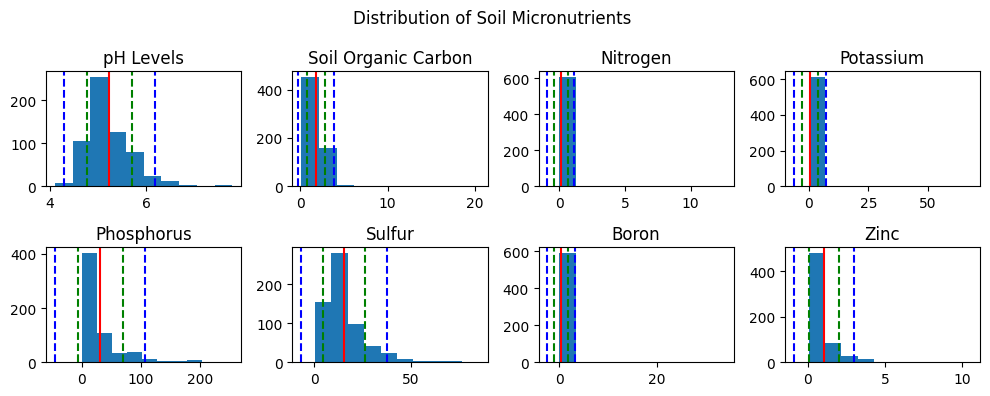

In [18]:
report_plotter = ReportPlotter(df, num_cols, num_col_names)
report_plotter.plot_micronutrients(kind='hist')

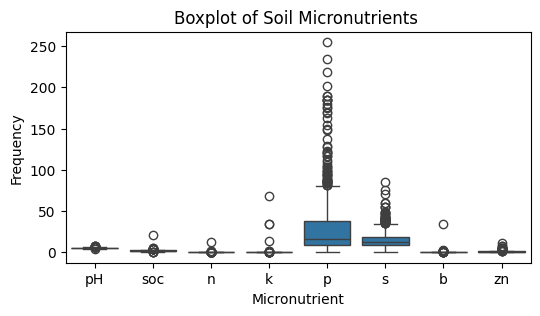

In [19]:
report_plotter.plot_micronutrients(kind='box')

### Dealing with Outliers

We can see in the plots in the previous section that there are notable patterns in the distribution of soil micronutrients. The boxplot indicates that several micronutrients, particularly **phosphorus (p)** and **sulfur (s)**, exhibit a significant number of outliers. These outliers suggest considerable variability in the concentrations of these nutrients, which could be due to environmental factors or sampling inconsistencies. In contrast, other nutrients such as pH, soc, n, k, b, and zn show fewer outliers, indicating more consistent levels across the samples. Addressing these outliers could be critical for ensuring accurate nutrient management and soil health assessments.

In [20]:
def get_outlier(data: pd.DataFrame, num_col: str) -> pd.Series:
    """
    Identify outliers in a specified numerical column based on the IQR method.

    This function calculates the interquartile range (IQR) for the specified column,
    defines the lower and upper bounds for outliers as 1.5 * IQR below Q1 and above Q3,
    and returns a boolean Series indicating whether each row in the column is an outlier.

    Args:
        data (pd.DataFrame): The input DataFrame containing the data.
        num_col (str): The name of the numerical column to check for outliers.

    Returns:
        pd.Series: A boolean Series where True indicates an outlier in the specified column.
    """
    q1 = data[num_col].quantile(0.25)
    q3 = data[num_col].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Use np.where to identify outliers efficiently
    return np.where((data[num_col] < lower_bound) | (data[num_col] > upper_bound), True, False)

#### Phosphorus

In [21]:
phosphorus_df = df[cat_cols + ['p']]
phosphorus_df.head()

,area,year_data_added,soil_group,land_class,soil_type,p
0,Mithpukur,2005,belab,high ground,Clay loam,19.6
1,Mithpukur,2005,belab,high ground,Clay loam,4.1
2,Mithpukur,2005,belab,high ground,Clay loam,13.3
3,Mithpukur,2005,belab,high ground,Clay loam,20.2
4,Mithpukur,2005,belab,high ground,Clay loam,20.5


In [22]:
phosphorus_outliers = phosphorus_df[get_outlier(phosphorus_df, 'p')]
phosphorus_non_outliers = phosphorus_df[~get_outlier(phosphorus_df, 'p')]

In [23]:
new_order = [col for pair in zip(df[num_cols].columns, cleaned_nums.add_prefix('after_').columns) for col in pair]

pd.concat([df[num_cols], cleaned_nums.add_prefix('after_')], axis=1)[new_order][non_numeric_mask.any(axis=1)]

,pH,after_pH,soc,after_soc,n,after_n,k,after_k,p,after_p,s,after_s,b,after_b,zn,after_zn
67,5.5,5.5,1.69,1.69,0.1000,0.1000,0.10,0.10,1.8000,1.8000,17.50,17.50,0.44,0.44,1.16,1.16
151,4.8,4.8,2.61,2.61,0.1500,0.1500,0.39,0.39,77.5000,77.5000,23.80,23.80,0.40,0.40,0.23,0.23
337,5.3,5.3,2.45,2.45,0.0600,0.0600,0.19,0.19,6.3000,6.3000,13.80,13.80,0.20,0.20,0.79,0.79
364,5.5,5.5,0.95,0.95,0.0032,0.0032,0.51,0.51,60.0000,60.0000,17.00,17.00,NaN,NaN,4.00,4.00
368,5.1,5.1,0.90,0.90,0.0015,0.0015,0.33,0.33,80.0000,80.0000,15.00,15.00,NaN,NaN,1.00,1.00
369,5.0,5.0,0.57,0.57,0.0018,0.0018,0.44,0.44,26.0000,26.0000,9.00,9.00,NaN,NaN,1.00,1.00
370,5.8,5.8,0.80,0.80,0.0019,0.0019,0.52,0.52,170.0000,170.0000,10.00,10.00,NaN,NaN,1.00,1.00
372,5.2,5.2,1.30,1.30,0.0010,0.0010,0.35,0.35,185.0000,185.0000,13.00,13.00,NaN,NaN,1.00,1.00
374,5.5,5.5,0.90,0.90,0.0017,0.0017,0.28,0.28,10.0000,10.0000,12.00,12.00,NaN,NaN,1.00,1.00
376,5.6,5.6,1.50,1.50,0.0035,0.0035,0.51,0.51,60.0000,60.0000,8.00,8.00,NaN,NaN,4.00,4.00


In [24]:
pd.concat(
    [
        phosphorus_outliers.p.describe().rename('outliers_p'),
        phosphorus_non_outliers.p.describe().rename('non_outliers_p')
    ],
    axis=1
)

,outliers_p,non_outliers_p
count,58.000000,559.00000
mean,127.419310,21.09413
std,45.183039,18.10795
min,81.000000,0.06000
25%,89.062500,8.00000
50%,111.000000,14.80000
75%,167.000000,28.10000
max,254.700000,80.00000


In [25]:
num_col_names

{'pH': 'pH Levels',
 'soc': 'Soil Organic Carbon',
 'n': 'Nitrogen',
 'k': 'Potassium',
 'p': 'Phosphorus',
 's': 'Sulfur',
 'b': 'Boron',
 'zn': 'Zinc'}

<Axes: title={'center': 'Distribution of Phosphorus (Outliers)'}>

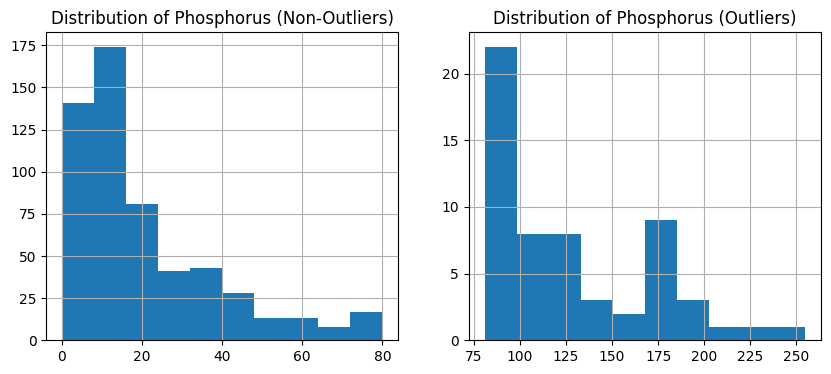

In [26]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Phosphorus (Outliers)')
arr[0].set_title('Distribution of Phosphorus (Non-Outliers)')
phosphorus_non_outliers.p.hist(ax=arr[0])
phosphorus_outliers.p.hist(ax=arr[1])

##### by land_class

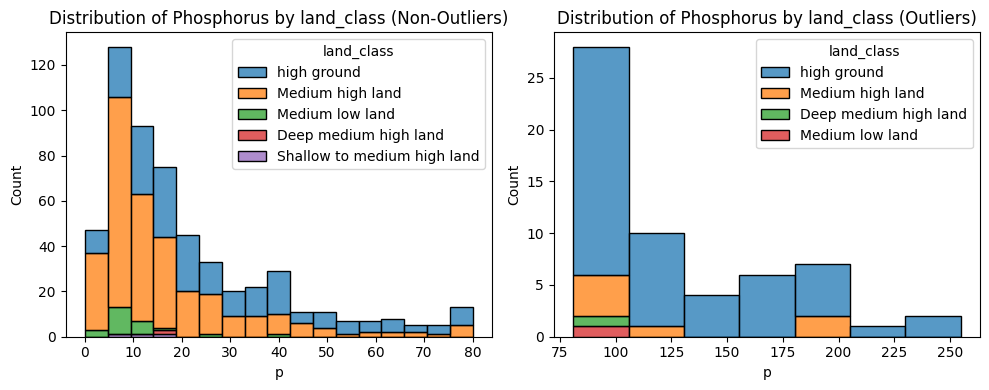

In [27]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Phosphorus by land_class (Outliers)')
arr[0].set_title('Distribution of Phosphorus by land_class (Non-Outliers)')

sns.histplot(data=phosphorus_non_outliers, x='p', hue='land_class', multiple='stack', ax=arr[0])
sns.histplot(data=phosphorus_outliers, x='p', hue='land_class', multiple='stack', ax=arr[1])
plt.tight_layout()

##### by soil_type

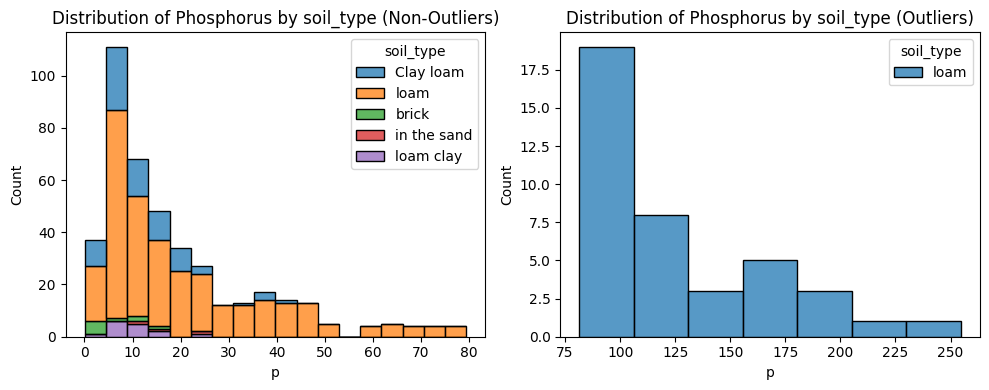

In [28]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Phosphorus by soil_type (Outliers)')
arr[0].set_title('Distribution of Phosphorus by soil_type (Non-Outliers)')

sns.histplot(data=phosphorus_non_outliers, x='p', hue='soil_type', multiple='stack', ax=arr[0])
sns.histplot(data=phosphorus_outliers, x='p', hue='soil_type', multiple='stack', ax=arr[1])
plt.tight_layout()

#### Sulphur

In [29]:
sulfur_df = df[cat_cols + ['s']]
sulfur_df.head()

,area,year_data_added,soil_group,land_class,soil_type,s
0,Mithpukur,2005,belab,high ground,Clay loam,37.7
1,Mithpukur,2005,belab,high ground,Clay loam,32.0
2,Mithpukur,2005,belab,high ground,Clay loam,13.5
3,Mithpukur,2005,belab,high ground,Clay loam,30.0
4,Mithpukur,2005,belab,high ground,Clay loam,27.8


In [30]:
sulfur_outliers = sulfur_df[get_outlier(sulfur_df, 's')]
sulfur_non_outliers = sulfur_df[~get_outlier(sulfur_df, 's')]

In [31]:
pd.concat(
    [
        sulfur_outliers.s.describe().rename('outliers_s'),
        sulfur_non_outliers.s.describe().rename('non_outliers_s')
    ],
    axis=1
)

,outliers_s,non_outliers_s
count,42.000000,576.000000
mean,44.866190,13.187774
std,11.287498,7.341964
min,35.000000,0.400000
25%,37.515000,8.262500
50%,40.855000,12.000000
75%,47.875000,17.200000
max,85.000000,34.000000


<Axes: title={'center': 'Distribution of Sulfur (Outliers)'}>

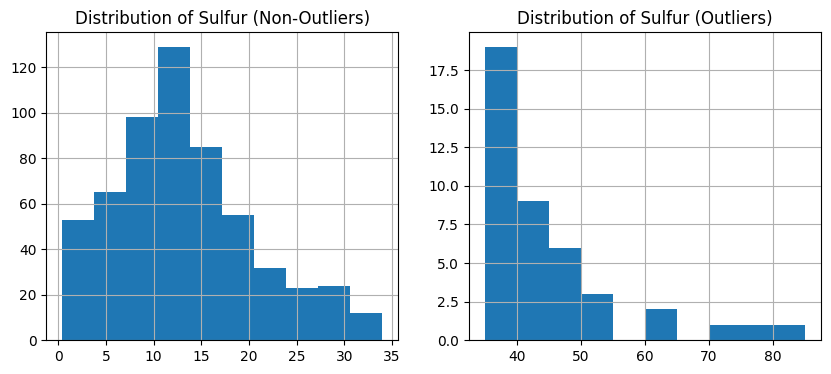

In [32]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Sulfur (Outliers)')
arr[0].set_title('Distribution of Sulfur (Non-Outliers)')
sulfur_non_outliers.s.hist(ax=arr[0])
sulfur_outliers.s.hist(ax=arr[1])

##### by land_class

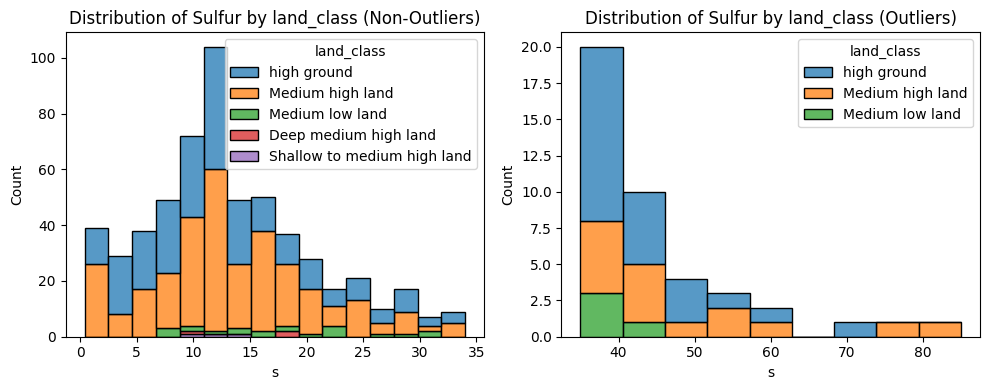

In [33]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Sulfur by land_class (Outliers)')
arr[0].set_title('Distribution of Sulfur by land_class (Non-Outliers)')

sns.histplot(data=sulfur_non_outliers, x='s', hue='land_class', multiple='stack', ax=arr[0])
sns.histplot(data=sulfur_outliers, x='s', hue='land_class', multiple='stack', ax=arr[1])
plt.tight_layout()

##### by soil_type

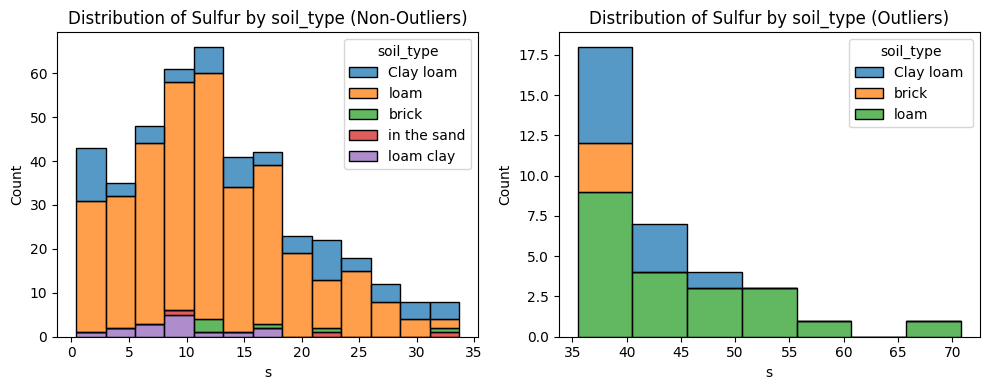

In [34]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Sulfur by soil_type (Outliers)')
arr[0].set_title('Distribution of Sulfur by soil_type (Non-Outliers)')

sns.histplot(data=sulfur_non_outliers, x='s', hue='soil_type', multiple='stack', ax=arr[0])
sns.histplot(data=sulfur_outliers, x='s', hue='soil_type', multiple='stack', ax=arr[1])
plt.tight_layout()

#### Potassium

In [35]:
potassium_df = df[cat_cols + ['k']]
potassium_df.head()

,area,year_data_added,soil_group,land_class,soil_type,k
0,Mithpukur,2005,belab,high ground,Clay loam,0.15
1,Mithpukur,2005,belab,high ground,Clay loam,0.25
2,Mithpukur,2005,belab,high ground,Clay loam,0.09
3,Mithpukur,2005,belab,high ground,Clay loam,0.30
4,Mithpukur,2005,belab,high ground,Clay loam,0.17


In [36]:
potassium_outliers = potassium_df[get_outlier(potassium_df, 'k')]
potassium_non_outliers = potassium_df[~get_outlier(potassium_df, 'k')]

In [37]:
pd.concat(
    [
        potassium_outliers.k.describe().rename('outliers_k'),
        potassium_non_outliers.k.describe().rename('non_outliers_k')
    ],
    axis=1
)

,outliers_k,non_outliers_k
count,25.000000,593.000000
mean,6.580400,0.201046
std,15.897056,0.118710
min,0.560000,0.000000
25%,0.600000,0.110000
50%,0.670000,0.170000
75%,0.800000,0.270000
max,68.000000,0.540000


<Axes: title={'center': 'Distribution of Potassium (Outliers)'}>

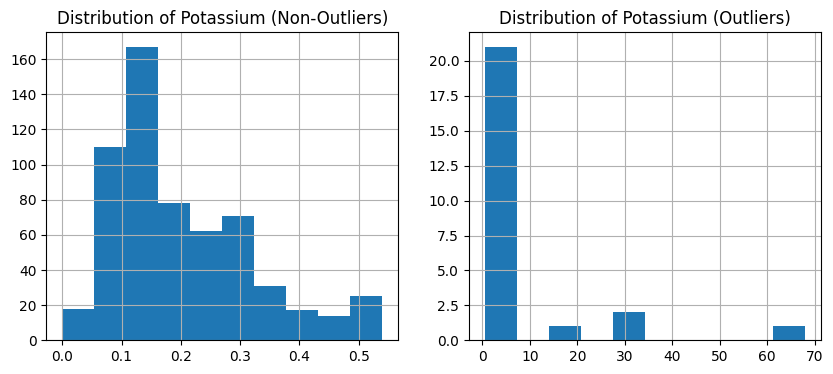

In [38]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Potassium (Outliers)')
arr[0].set_title('Distribution of Potassium (Non-Outliers)')
potassium_non_outliers.k.hist(ax=arr[0])
potassium_outliers.k.hist(ax=arr[1])

##### by land_class

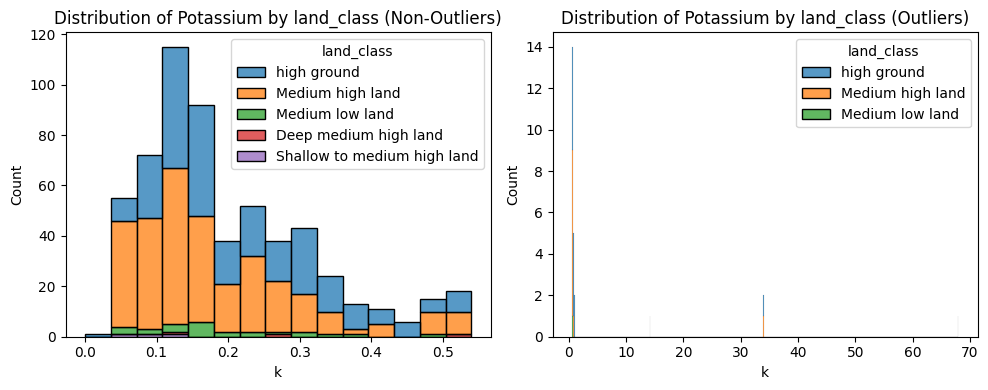

In [39]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Potassium by land_class (Outliers)')
arr[0].set_title('Distribution of Potassium by land_class (Non-Outliers)')

sns.histplot(data=potassium_non_outliers, x='k', hue='land_class', multiple='stack', ax=arr[0])
sns.histplot(data=potassium_outliers, x='k', hue='land_class', multiple='stack', ax=arr[1])
plt.tight_layout()

##### by soil_type

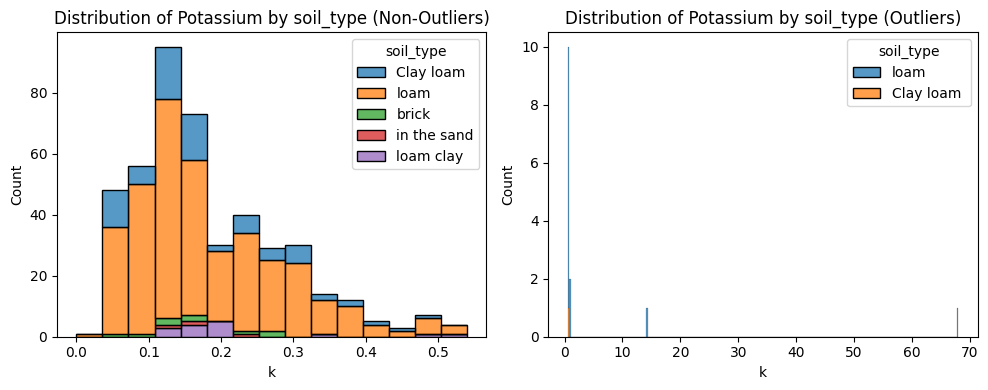

In [40]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Potassium by soil_type (Outliers)')
arr[0].set_title('Distribution of Potassium by soil_type (Non-Outliers)')

sns.histplot(data=potassium_non_outliers, x='k', hue='soil_type', multiple='stack', ax=arr[0])
sns.histplot(data=potassium_outliers, x='k', hue='soil_type', multiple='stack', ax=arr[1])
plt.tight_layout()

#### Soil Organic Carbon

In [41]:
soc_df = df[cat_cols + ['soc']]
soc_df.head()

,area,year_data_added,soil_group,land_class,soil_type,soc
0,Mithpukur,2005,belab,high ground,Clay loam,1.27
1,Mithpukur,2005,belab,high ground,Clay loam,1.47
2,Mithpukur,2005,belab,high ground,Clay loam,1.07
3,Mithpukur,2005,belab,high ground,Clay loam,1.51
4,Mithpukur,2005,belab,high ground,Clay loam,1.08


In [42]:
soc_outliers = soc_df[get_outlier(soc_df, 'soc')]
soc_non_outliers = soc_df[~get_outlier(soc_df, 'soc')]

In [43]:
pd.concat(
    [
        soc_outliers.soc.describe().rename('outliers_soc'),
        soc_non_outliers.soc.describe().rename('non_outliers_soc')
    ],
    axis=1
)

,outliers_soc,non_outliers_soc
count,20.000000,598.000000
mean,3.977000,1.719144
std,4.197128,0.615968
min,0.100000,0.160000
25%,3.395000,1.350000
50%,3.585000,1.690000
75%,4.055000,2.117500
max,20.400000,3.300000


<Axes: title={'center': 'Distribution of Soil Organic Carbon (Outliers)'}>

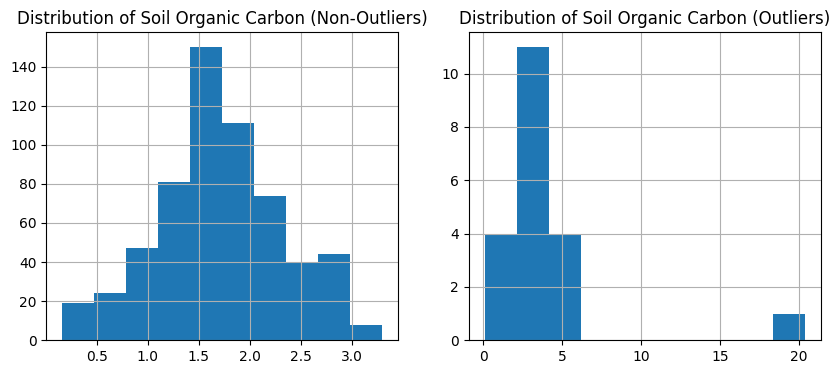

In [44]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Soil Organic Carbon (Outliers)')
arr[0].set_title('Distribution of Soil Organic Carbon (Non-Outliers)')
soc_non_outliers.soc.hist(ax=arr[0])
soc_outliers.soc.hist(ax=arr[1])

##### by land_class

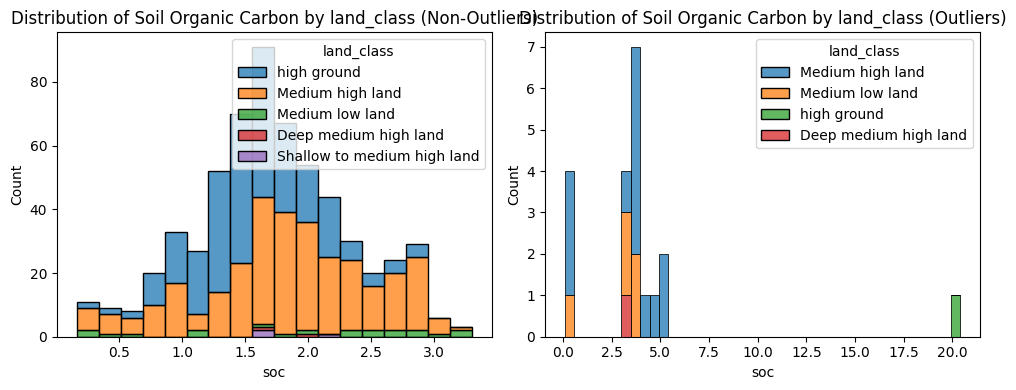

In [45]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Soil Organic Carbon by land_class (Outliers)')
arr[0].set_title('Distribution of Soil Organic Carbon by land_class (Non-Outliers)')

sns.histplot(data=soc_non_outliers, x='soc', hue='land_class', multiple='stack', ax=arr[0])
sns.histplot(data=soc_outliers, x='soc', hue='land_class', multiple='stack', ax=arr[1])
plt.tight_layout()

##### by soil_type

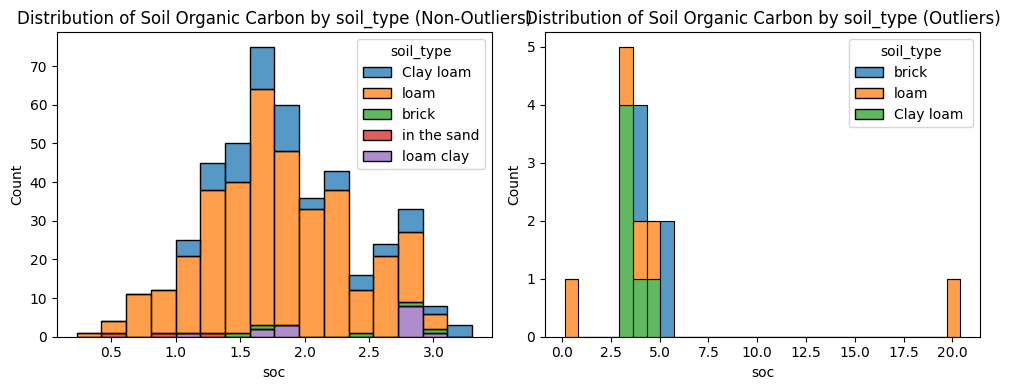

In [46]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Soil Organic Carbon by soil_type (Outliers)')
arr[0].set_title('Distribution of Soil Organic Carbon by soil_type (Non-Outliers)')

sns.histplot(data=soc_non_outliers, x='soc', hue='soil_type', multiple='stack', ax=arr[0])
sns.histplot(data=soc_outliers, x='soc', hue='soil_type', multiple='stack', ax=arr[1])
plt.tight_layout()

#### Boron

In [47]:
boron_df = df[cat_cols + ['b']]
boron_df.head()

,area,year_data_added,soil_group,land_class,soil_type,b
0,Mithpukur,2005,belab,high ground,Clay loam,0.26
1,Mithpukur,2005,belab,high ground,Clay loam,0.25
2,Mithpukur,2005,belab,high ground,Clay loam,0.27
3,Mithpukur,2005,belab,high ground,Clay loam,0.28
4,Mithpukur,2005,belab,high ground,Clay loam,0.30


In [48]:
boron_outliers = boron_df[get_outlier(boron_df, 'b')]
boron_non_outliers = boron_df[~get_outlier(boron_df, 'b')]

In [49]:
pd.concat(
    [
        boron_outliers.b.describe().rename('outliers_boron'),
        boron_non_outliers.b.describe().rename('non_outliers_boron')
    ],
    axis=1
)

,outliers_boron,non_outliers_boron
count,37.000000,555.000000
mean,2.051351,0.312505
std,5.413859,0.114168
min,0.680000,0.060000
25%,0.880000,0.230000
50%,1.100000,0.300000
75%,1.400000,0.380000
max,34.000000,0.640000


<Axes: title={'center': 'Distribution of Boron (Outliers)'}>

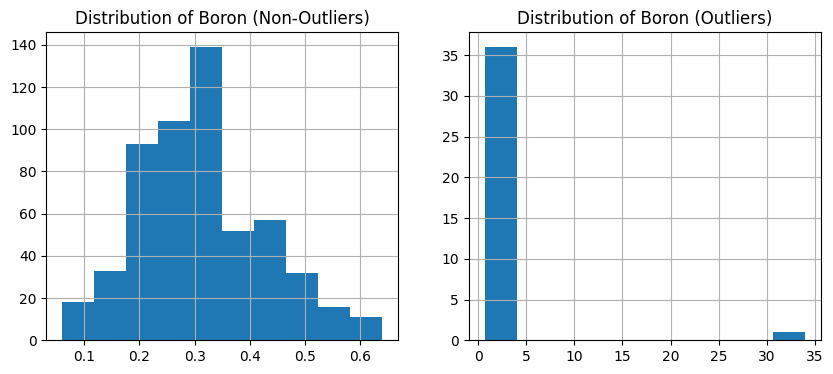

In [50]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Boron (Outliers)')
arr[0].set_title('Distribution of Boron (Non-Outliers)')
boron_non_outliers.b.hist(ax=arr[0])
boron_outliers.b.hist(ax=arr[1])

##### by land_class

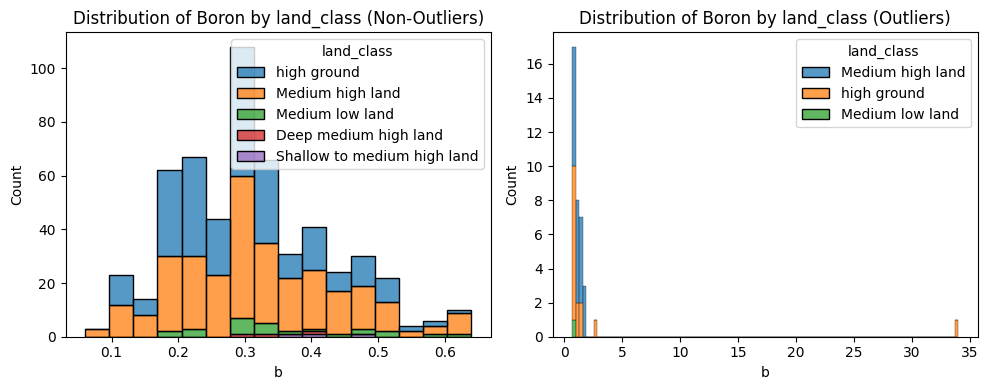

In [51]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Boron by land_class (Outliers)')
arr[0].set_title('Distribution of Boron by land_class (Non-Outliers)')

sns.histplot(data=boron_non_outliers, x='b', hue='land_class', multiple='stack', ax=arr[0])
sns.histplot(data=boron_outliers, x='b', hue='land_class', multiple='stack', ax=arr[1])
plt.tight_layout()

##### by soil_type

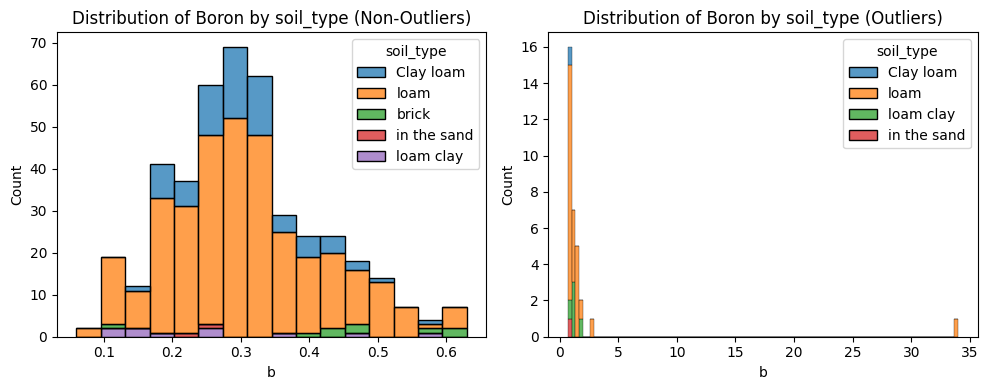

In [52]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Boron by soil_type (Outliers)')
arr[0].set_title('Distribution of Boron by soil_type (Non-Outliers)')

sns.histplot(data=boron_non_outliers, x='b', hue='soil_type', multiple='stack', ax=arr[0])
sns.histplot(data=boron_outliers, x='b', hue='soil_type', multiple='stack', ax=arr[1])
plt.tight_layout()

#### Zinc

In [53]:
zinc_df = df[cat_cols + ['zn']]
zinc_df.head()

,area,year_data_added,soil_group,land_class,soil_type,zn
0,Mithpukur,2005,belab,high ground,Clay loam,0.86
1,Mithpukur,2005,belab,high ground,Clay loam,0.75
2,Mithpukur,2005,belab,high ground,Clay loam,0.95
3,Mithpukur,2005,belab,high ground,Clay loam,1.00
4,Mithpukur,2005,belab,high ground,Clay loam,1.04


In [54]:
zinc_outliers = zinc_df[get_outlier(zinc_df, 'zn')]
zinc_non_outliers = zinc_df[~get_outlier(zinc_df, 'zn')]

In [55]:
pd.concat(
    [
        zinc_outliers.zn.describe().rename('outliers_zinc'),
        zinc_non_outliers.zn.describe().rename('non_outliers_zinc')
    ],
    axis=1
)

,outliers_zinc,non_outliers_zinc
count,56.000000,562.000000
mean,3.505714,0.793416
std,1.548654,0.380842
min,2.010000,0.080000
25%,2.575000,0.500000
50%,3.000000,0.780000
75%,4.000000,1.000000
max,10.580000,1.930000


<Axes: title={'center': 'Distribution of Zinc (Outliers)'}>

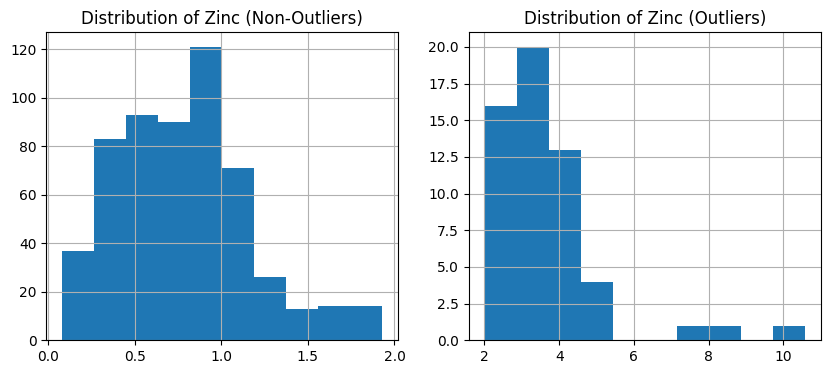

In [56]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Zinc (Outliers)')
arr[0].set_title('Distribution of Zinc (Non-Outliers)')
zinc_non_outliers.zn.hist(ax=arr[0])
zinc_outliers.zn.hist(ax=arr[1])

##### by land_class

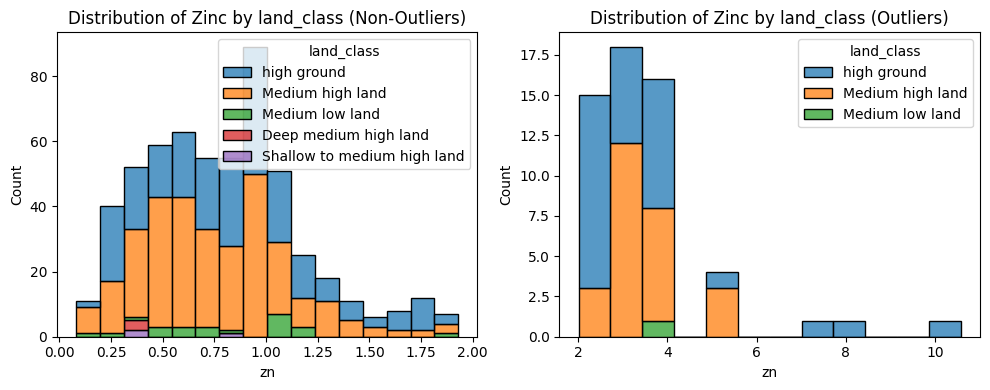

In [57]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Zinc by land_class (Outliers)')
arr[0].set_title('Distribution of Zinc by land_class (Non-Outliers)')

sns.histplot(data=zinc_non_outliers, x='zn', hue='land_class', multiple='stack', ax=arr[0])
sns.histplot(data=zinc_outliers, x='zn', hue='land_class', multiple='stack', ax=arr[1])
plt.tight_layout()

##### by soil_type

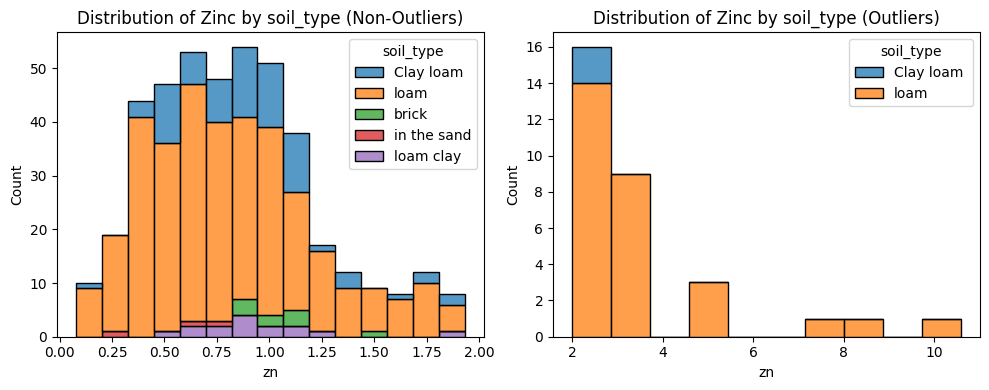

In [58]:
fig, arr = plt.subplots(1, 2, figsize=(10, 4))
arr[1].set_title('Distribution of Zinc by soil_type (Outliers)')
arr[0].set_title('Distribution of Zinc by soil_type (Non-Outliers)')

sns.histplot(data=zinc_non_outliers, x='zn', hue='soil_type', multiple='stack', ax=arr[0])
sns.histplot(data=zinc_outliers, x='zn', hue='soil_type', multiple='stack', ax=arr[1])
plt.tight_layout()

#### Filtering Outliers

In [113]:
outlier_maps = [get_outlier(df, col) for col in num_cols]

In [114]:
from functools import reduce
combined_outlier_map = reduce(lambda x, y: x | y, outlier_maps)

In [115]:
filtered_df = df[~combined_outlier_map]
filtered_df.head()

,area,year_data_added,soil_group,land_class,soil_type,pH,soc,n,k,p,s,b,zn
1,Mithpukur,2005,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75
2,Mithpukur,2005,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95
3,Mithpukur,2005,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.00
4,Mithpukur,2005,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04
5,Mithpukur,2005,belab,high ground,Clay loam,4.9,1.87,0.08,0.35,21.7,27.8,0.32,1.16


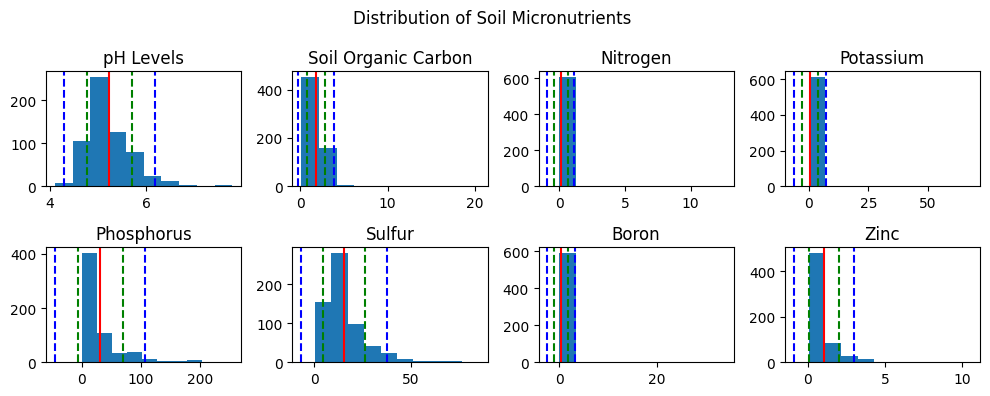

In [116]:
report_plotter = ReportPlotter(df, num_cols, num_col_names)
report_plotter.plot_micronutrients(kind='hist')

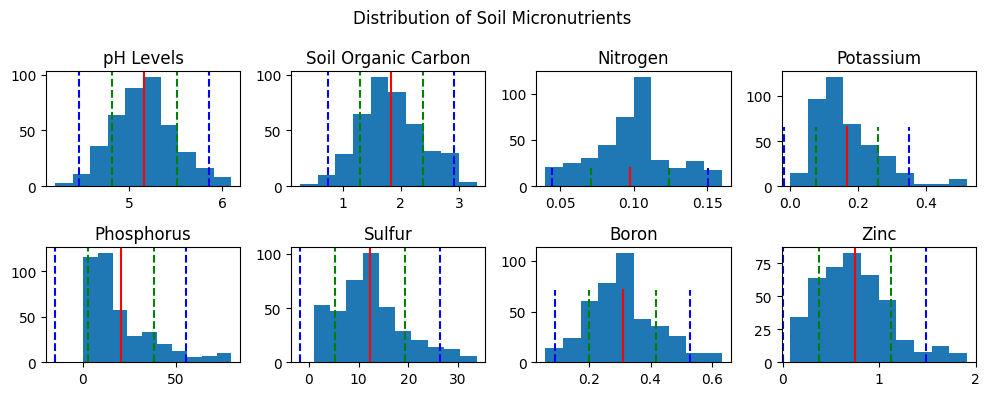

In [117]:
report_plotter = ReportPlotter(filtered_df, num_cols, num_col_names)
report_plotter.plot_micronutrients(kind='hist')

### Nulls

In [118]:
filtered_df.isna().sum()

,0
area,0
year_data_added,0
soil_group,0
land_class,0
soil_type,82
pH,0
soc,0
n,3
k,0
p,1


In [119]:
nulls_df = filtered_df[filtered_df.isna().any(axis=1)]
nulls_df.head()

,area,year_data_added,soil_group,land_class,soil_type,pH,soc,n,k,p,s,b,zn
389,Gangachara,1990,Gangachara,Medium high land,NaN,5.4,2.40,NaN,0.34,24.0,2.00,NaN,1.00
390,Gangachara,1990,Gangachara,Medium high land,NaN,4.8,2.90,NaN,0.47,27.0,2.00,NaN,1.00
412,Gangachara,1990,Alluvial soil of Teesta,Medium high land,NaN,5.9,0.27,NaN,0.47,25.0,12.00,NaN,1.00
472,Kaunia upazila,2016,Gangachara,Medium high land,loam,5.0,2.82,0.14,0.13,NaN,11.78,0.23,0.63
521,Taraganj Thana,1997,belab,high ground,NaN,5.3,2.15,0.12,0.22,12.0,28.00,0.42,0.98


In [121]:
# all missing macronutrients are already in the missing soil_types
filtered_df[~filtered_df.isna().any(axis=1)].isna().sum()

,0
area,0
year_data_added,0
soil_group,0
land_class,0
soil_type,0
pH,0
soc,0
n,0
k,0
p,0


Most Missing Soil Types are from Medium High Land and High Ground

In [127]:
nulls_df.groupby(['area', 'land_class']).count()

year_data_added  soil_group  \
area           land_class                                                 
Gangachara     Medium high land                           3           3   
Kaunia upazila Medium high land                           1           1   
Taraganj Thana Deep medium high land                      1           1   
               Medium high land                          49          49   
               Medium low land                            1           1   
               Shallow to medium high land                3           3   
               high ground                               25          25   

                                            soil_type  pH  soc   n   k   p  \
area           land_class                                                    
Gangachara     Medium high land                     0   3    3   0   3   3   
Kaunia upazila Medium high land                     1   1    1   1   1   0   
Taraganj Thana Deep medium high land                0   1    1   1   1   1   
               Medium high land                     0  49   49  49  49  49   
               Medium low land                      0   1    1   1   1   1   
               Shallow to medium high land          0   3    3   3   3   3   
               high ground                          0  25   25  25  25  25   

                                             s   b  zn  
area           land_class                               
Gangachara     Medium high land              3   0   3  
Kaunia upazila Medium high land              1   1   1  
Taraganj Thana Deep medium high land         1   1   1  
               Medium high land             49  49  49  
               Medium low land               1   1   1  
               Shallow to medium high land   3   3   3  
               high ground                  25  25  25

#### Filtering Nulls

In [129]:
filtered_df = filtered_df.dropna()
filtered_df.isna().sum()

,0
area,0
year_data_added,0
soil_group,0
land_class,0
soil_type,0
pH,0
soc,0
n,0
k,0
p,0


### Correlation Analysis of Micronutrients

<Axes: >

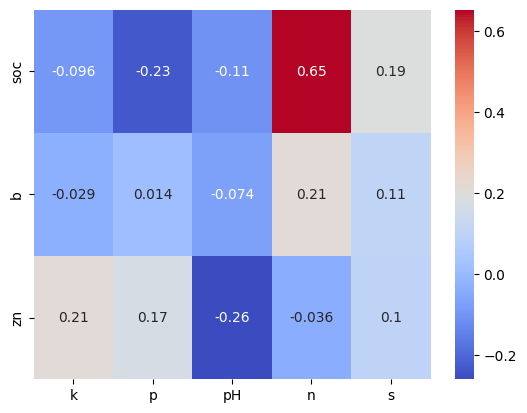

In [131]:
import seaborn as sns
cor = filtered_df[num_cols].corr()
target_cols = ['soc', 'b', 'zn']
sns.heatmap(cor[list(set(num_cols) - set(target_cols))].loc[target_cols], annot=True, cmap='coolwarm')

#### Distribution of Micronutrient Levels by Land Class

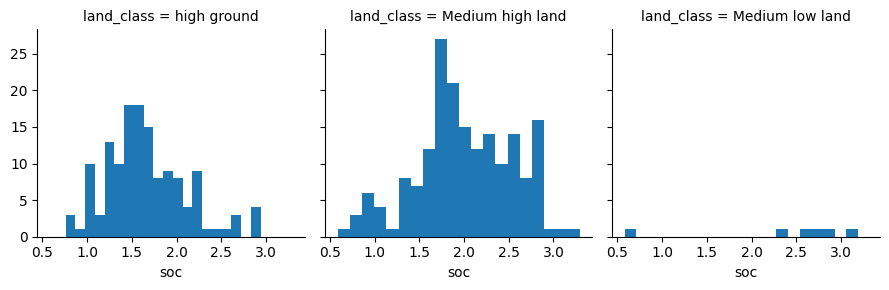

In [132]:
g = sns.FacetGrid(filtered_df,col='land_class')
g.map(plt.hist, 'soc', bins=20)

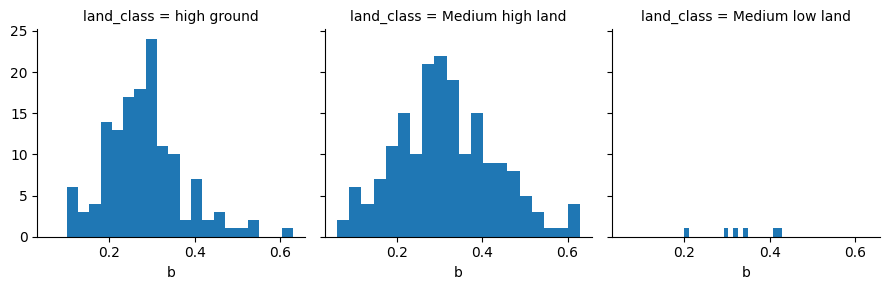

In [133]:
g = sns.FacetGrid(filtered_df,col='land_class')
g.map(plt.hist, 'b', bins=20)

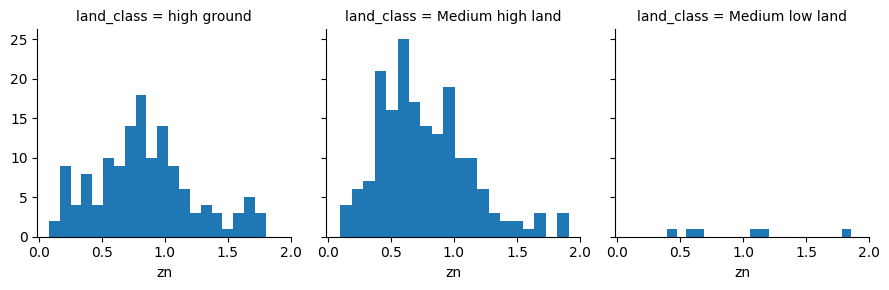

In [134]:
g = sns.FacetGrid(filtered_df,col='land_class')
g.map(plt.hist, 'zn', bins=20)

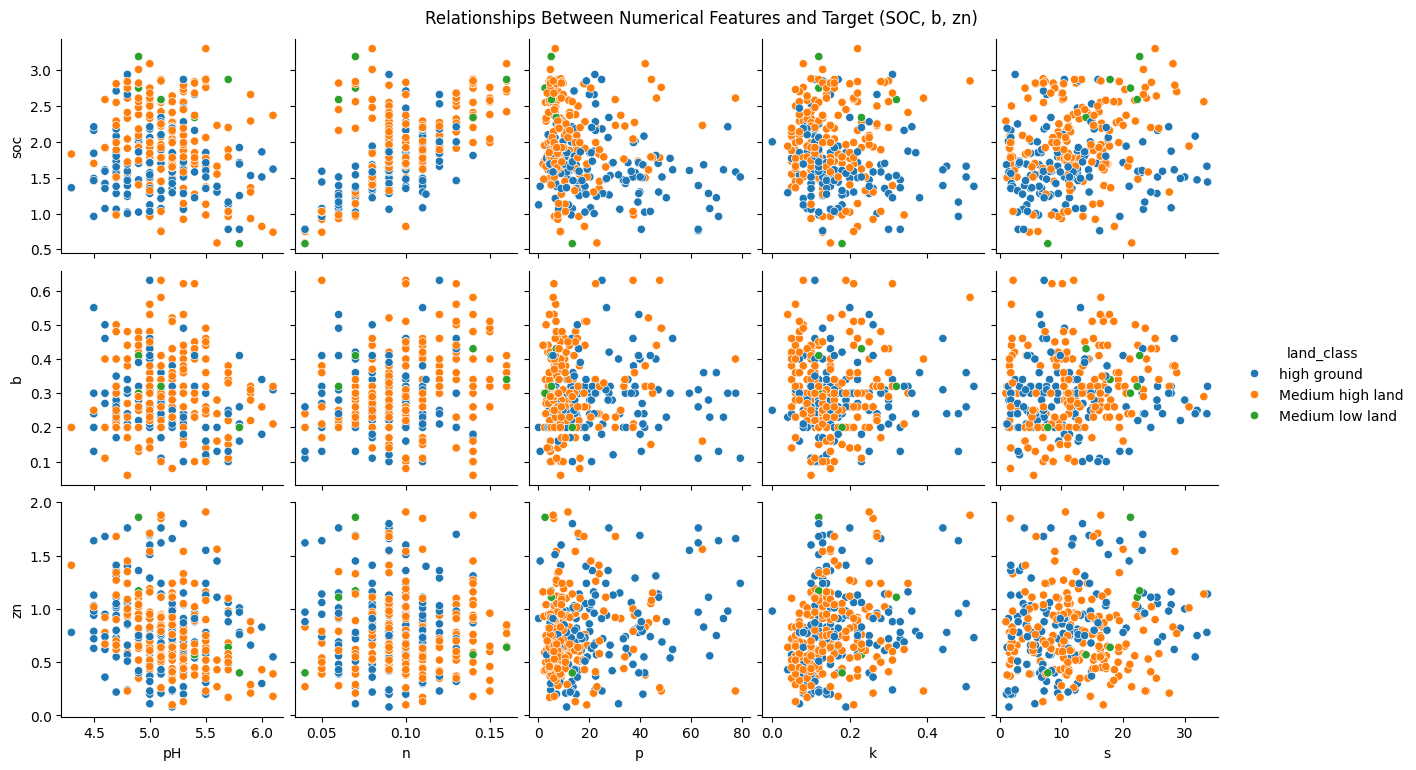

In [135]:
# Select only the relevant columns
sns.pairplot(
    filtered_df,
    x_vars=['pH', 'n', 'p', 'k', 's'],
    y_vars=['soc', 'b', 'zn'],
    height=2.5,
    aspect=1,
    hue='land_class'
)
plt.suptitle("Relationships Between Numerical Features and Target (SOC, b, zn)", y=1.02)
plt.show()

#### Distribution of Micronutrient Levels by Soil Type

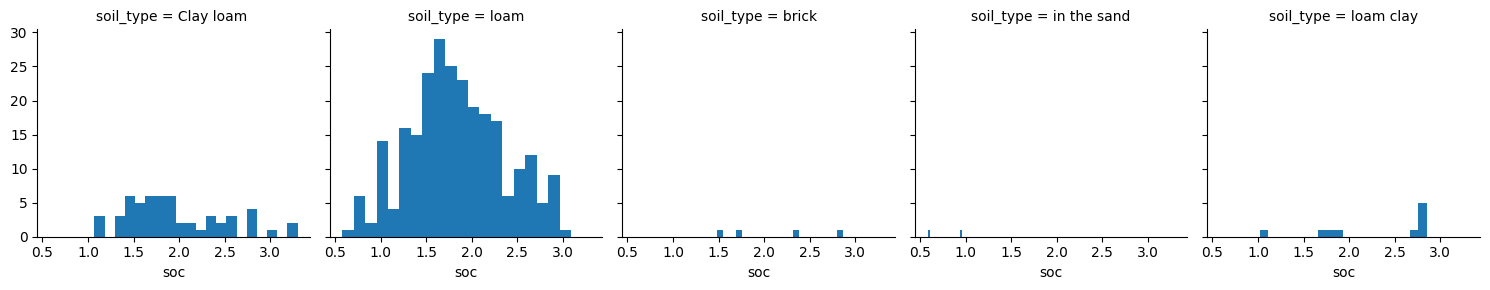

In [136]:
g = sns.FacetGrid(filtered_df,col='soil_type')
g.map(plt.hist, 'soc', bins=20)

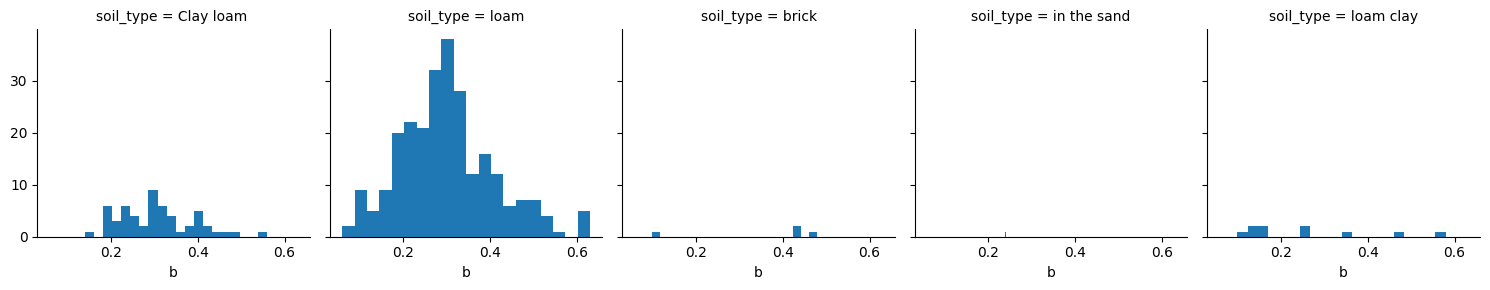

In [137]:
g = sns.FacetGrid(filtered_df,col='soil_type')
g.map(plt.hist, 'b', bins=20)

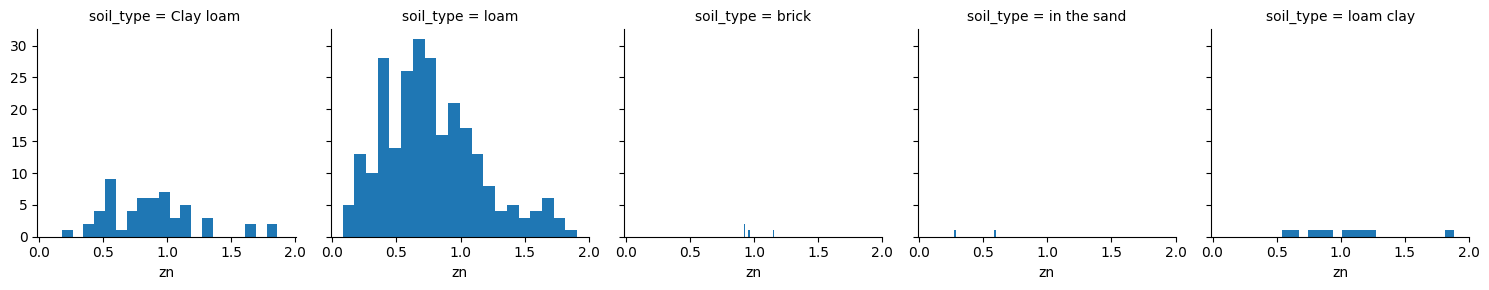

In [138]:
g = sns.FacetGrid(filtered_df,col='soil_type')
g.map(plt.hist, 'zn', bins=20)

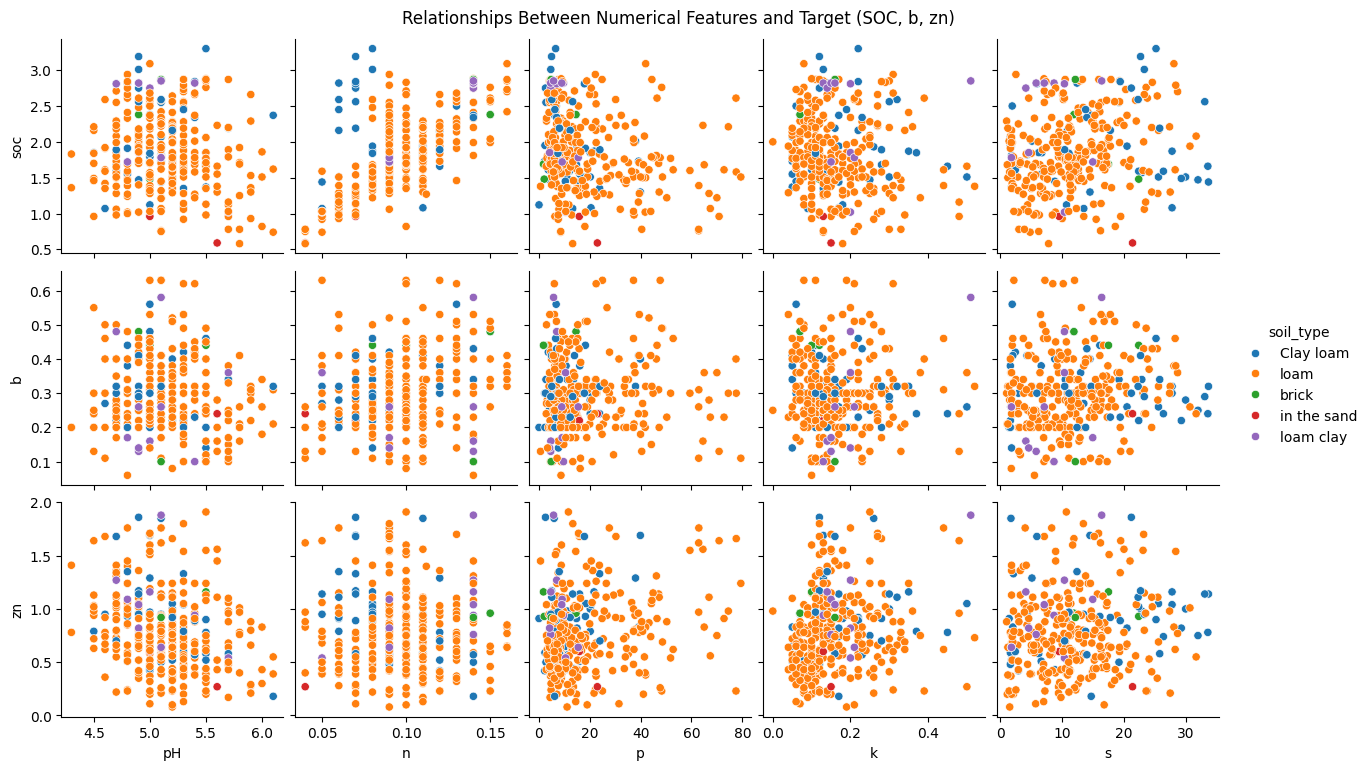

In [139]:
# Select only the relevant columns
sns.pairplot(
    filtered_df,
    x_vars=['pH', 'n', 'p', 'k', 's'],
    y_vars=['soc', 'b', 'zn'],
    height=2.5,
    aspect=1,
    hue='soil_type'
)
plt.suptitle("Relationships Between Numerical Features and Target (SOC, b, zn)", y=1.02)
plt.show()

#### Micronutrient Levels by Soil Type and Land Class

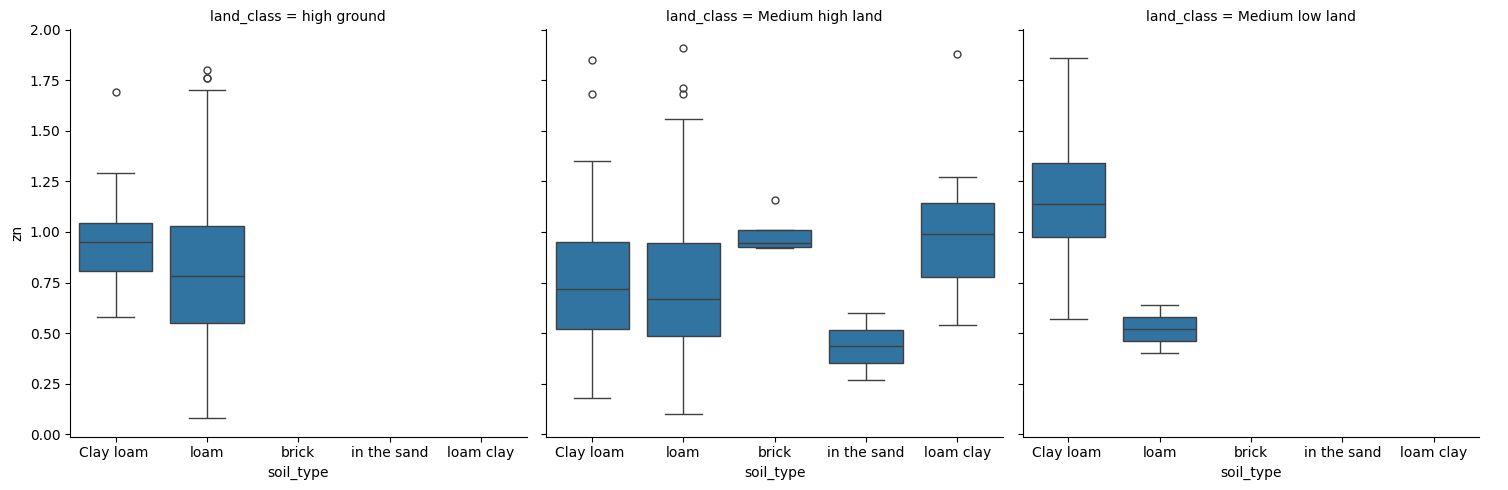

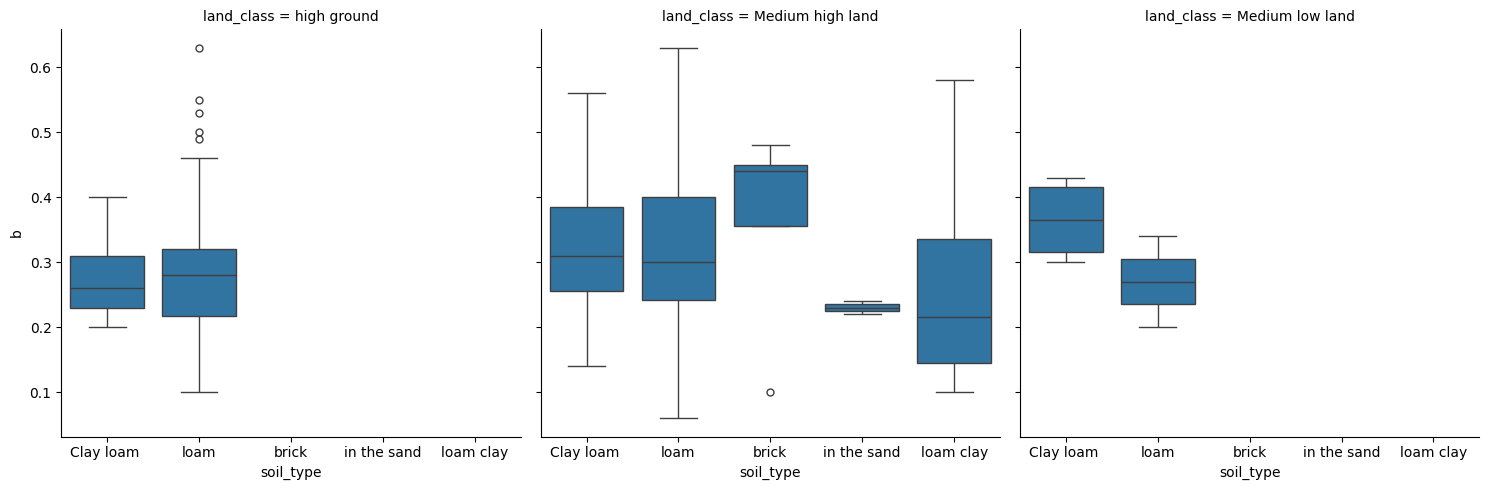

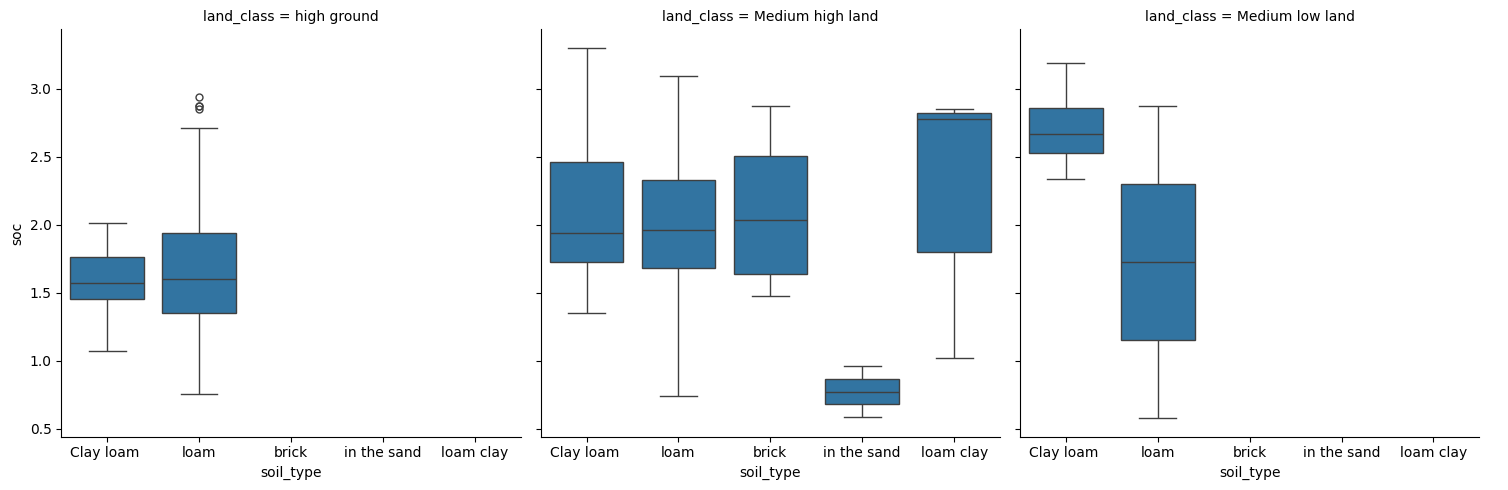

In [140]:
g = sns.catplot(data=filtered_df, x='soil_type', y='zn', col='land_class', kind='box')
g = sns.catplot(data=filtered_df, x='soil_type', y='b', col='land_class', kind='box')
g = sns.catplot(data=filtered_df, x='soil_type', y='soc', col='land_class', kind='box')